In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [4]:
import csv

# Context

The data for the analysis was taken from a competition on the Kaggle platform named 'Tabular Playground Series - Apr 2021': www.kaggle.com/c/tabular-playground-series-apr-2021. The dataset used for this competition is synthetic but based on a real Titanic dataset and generated using a CTGAN.

In [ ]:
dataset_url = 'https://www.kaggle.com/c/tabular-playground-series-apr-2021' 
import opendatasets as od
od.download(dataset_url)

In [5]:
FILE_NAME = './tabular-playground-series-apr-2021/train.csv'

In [6]:
TBS_train = pd.read_csv(FILE_NAME, index_col='PassengerId')

In [7]:
TBS_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


# Data quality assessment

Let's look at the shape of our DataFrame:

In [8]:
TBS_train.shape

(100000, 11)

...and compare it to the number of rows and columns in the initial file:

In [21]:
with open("./tabular-playground-series-apr-2021/train.csv") as initial_file:
    reader = csv.reader(initial_file)
    row_num = len(list(reader))
    print(f'Initial file has {row_num} rows', end=' ')
    initial_file.seek(0)
    col_num = len(next(reader))
    print(f'and {col_num} columns.')

Initial file has 100001 rows and 12 columns.


We can spot one extra unit each in the number of columns and rows. This is the row with column names and the column `PassengerId`, so all the data were loaded.
This also proves that it is possible to use the column `PassengerId` as an index.

Let's look if there are duplicated indexes:

In [30]:
TBS_train[TBS_train.index.duplicated()].shape[0]

0

...and rows:

In [32]:
TBS_train[TBS_train.duplicated()].shape[0]

0

Let's look at the number of non-null cells for each column and their data type.

In [9]:
TBS_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


As we can see, data types have been defined correctly.

Let's take a look at the number and the percentage of missing values:

In [49]:
missing_values = pd.DataFrame(TBS_train.isna().sum(), columns=['Count'])
missing_values['% of all'] = missing_values.Count / TBS_train.shape[0] * 100
missing_values

,Count,% of all
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
Age,3292,3.292
SibSp,0,0.000
Parch,0,0.000
Ticket,4623,4.623
Fare,134,0.134
Cabin,67866,67.866


As we can see, columns `Fare` and `Embarked` have a low percentage (< 0.5%) of missing data, columns `Age` and `Ticket` - a higher percentage (< 5%) and the column `Cabin` is two-thirds (≈66%) empty.

Now let's check the summary statistics of quantitative features to verify if there are impossible values.

In [10]:
TBS_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


Let's check if there are inappropriate values in columns with categorical features.

In [10]:
categorical_col = ['Sex', 'Survived', 'Pclass', 'Embarked']
for col in categorical_col:
    print(f'Unique values in column "{col}": {TBS_train[col].unique()}')

Unique values in column "Sex": ['male' 'female']
Unique values in column "Survived": [1 0]
Unique values in column "Pclass": [1 3 2]
Unique values in column "Embarked": ['S' 'C' 'Q' nan]


Values in the Data Dictionary described on the competition website are equal.

Let's check sime samples.

In [18]:
TBS_train.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
27294,0,1,"Schuette, Kristina",female,56.0,0,0,STON/O 34445,28.12,NaN,S
24955,0,2,"Stillman, Wally",male,29.0,0,0,12666,25.53,NaN,S
1358,0,3,"Martinez, Coleman",male,69.0,0,0,11102,8.01,NaN,S
67972,1,1,"Watson, Elois",female,76.0,0,2,341632,112.90,B13752,Q
22971,0,3,"Torres, Steve",male,0.5,1,2,497791,29.23,NaN,C
71262,0,3,"Moody, Thomas",male,19.0,0,1,4085964,9.81,NaN,S
2357,1,1,"Jones, Melissa",female,45.0,0,0,PC 189907,184.59,C13117,S
26748,1,2,"Filmore, Paul",male,55.0,0,0,9575,5.67,NaN,S
42113,0,1,"Swan, Gregory",male,30.0,0,0,28582,112.19,C19229,C


# Data exploration

Let's examine correlation between numeric variables.

<AxesSubplot:>

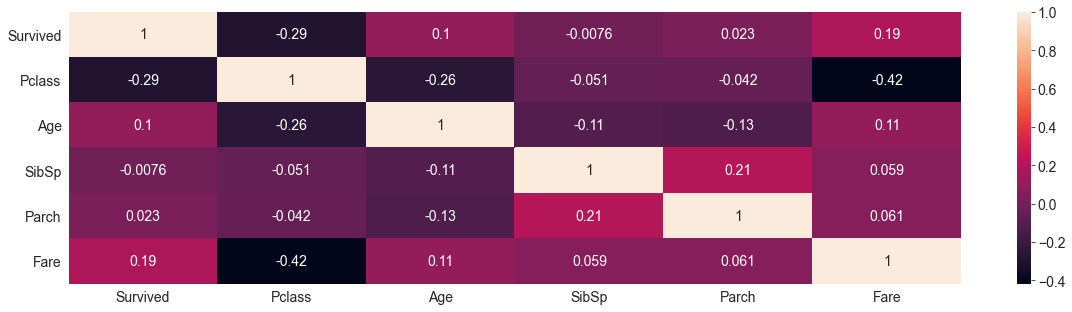

In [11]:
sns.heatmap(TBS_train.corr(), annot=True)

The heatmap shows a fairly strong linear relationship between Surviving and Ticket class, Ticket class and Passenger fare, Ticket class and Age, number of vertical and horizontal family relationships.

Statistic summary of continuous features:

In [19]:
continuous_col = ['Age', 'SibSp', 'Parch', 'Fare']

In [95]:
# mean and standart deviation are most interesting indicators
TBS_train[continuous_col].describe()

,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,99866.00000
mean,38.376690,0.397690,0.454560,43.92933
std,18.009956,0.862566,0.950076,69.58882
min,0.080000,0.000000,0.000000,0.68000
25%,25.000000,0.000000,0.000000,10.04000
50%,39.000000,0.000000,0.000000,24.46000
75%,53.000000,1.000000,1.000000,33.50000
max,87.000000,8.000000,9.000000,744.66000


In [20]:
TBS_train[continuous_col].mode()

,Age,SibSp,Parch,Fare
0,25.0,0.0,0.0,9.27
1,NaN,NaN,NaN,9.85


In [111]:
stat_measures = []
for col in continuous_col[:-1]:
    Q3 = np.quantile(TBS_train[col], 0.75)
    Q1 = np.quantile(TBS_train[col], 0.25)
    IQR = Q3 - Q1
    intq_mean = TBS_train[(TBS_train[col] <= Q3) & (TBS_train[col] >= Q1)][col].mean()
    range_ = TBS_train[col].max() - TBS_train[col].min()
    variance = np.square(TBS_train[col].std())
    stat_measures.append([intq_mean, IQR, range_, variance])
stat_measures = pd.DataFrame(data=stat_measures, index=continuous_col[:-1], columns=['Interquartile mean', 'IQR', 'Range', 'Variance'])
stat_measures

,Interquartile mean,IQR,Range,Variance
Age,38.660259,28.0,86.92,324.358520
SibSp,0.212301,1.0,8.00,0.744020
Parch,0.150180,1.0,9.00,0.902644


Let's check the distribution of survived passengers.

In [16]:
TBS_train.Survived.value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

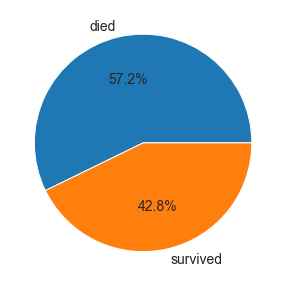

In [21]:
plt.pie(TBS_train.Survived.value_counts(), labels=['died', 'survived'], autopct='%1.1f%%')

plt.show()

Let's examine the distribution of Sex feature.

In [26]:
sex_distr = TBS_train.Sex.value_counts()
sex_distr

male      56114
female    43886
Name: Sex, dtype: int64

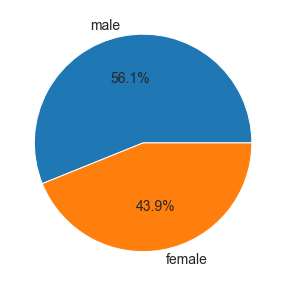

In [28]:
plt.pie(sex_distr, labels=sex_distr.index, autopct='%1.1f%%')
plt.show()

Let's examine the effect of Sex on survival rate.

In [34]:
surv_by_sex = TBS_train.groupby('Sex').mean()['Survived']
surv_by_sex

Sex
female    0.711525
male      0.205795
Name: Survived, dtype: float64

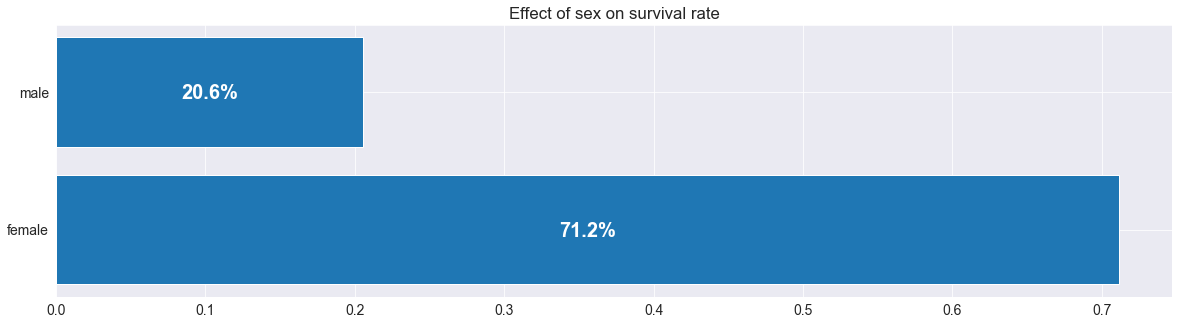

In [69]:
fig, ax = plt.subplots()
ax.barh(surv_by_sex.index, surv_by_sex.values)
for i in ax.patches:
    plt.text(i.get_width() / 2, i.get_y()+0.35,
             s=str(round((i.get_width()) * 100, 1)) + '%',
             fontsize=20, fontweight='bold',
             color='white', ha='center')
plt.title('Effect of sex on survival rate')
plt.show()

=> 71% of female passengers and only slightly more than 20% of male passengers survived.
It can be concluded that the probability of survival depended on the gender of the passenger, which is most likely due to cultural customs and rules of etiquette (first help women, children and the elderly), as well as the internal rules of the ship.

Let's examine the distribution of the age feature.

<AxesSubplot:xlabel='Age'>

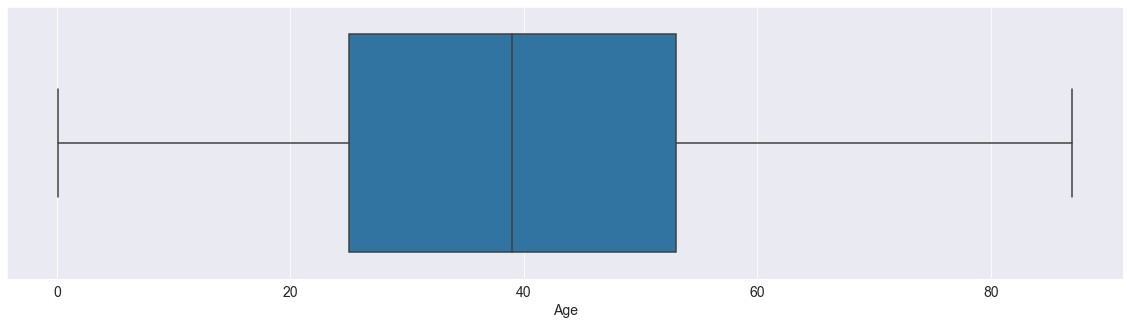

In [21]:
sns.boxplot(x = TBS_train.Age)

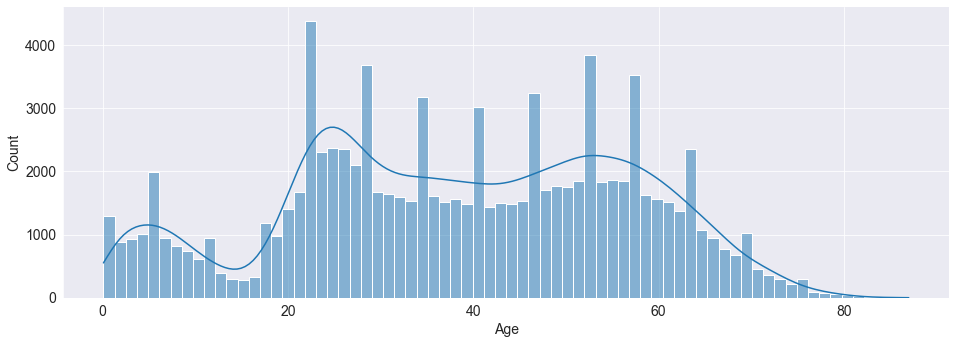

In [93]:
sns.displot(data=TBS_train.Age, kde=True, aspect=2.7)

Let's examine the effect of age on survival rate.

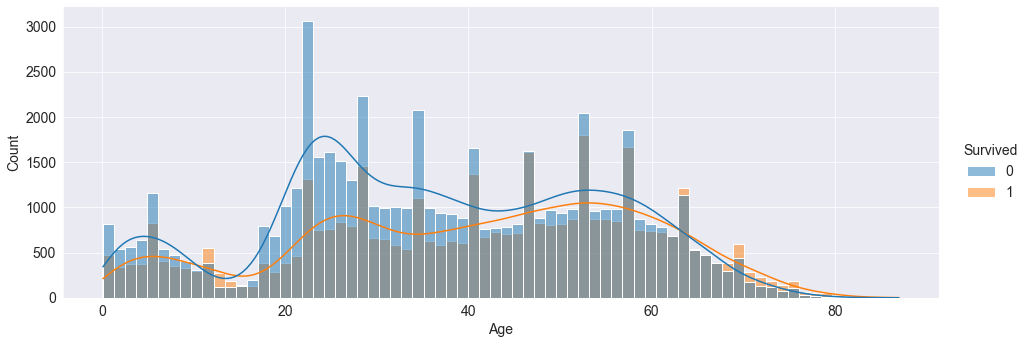

In [92]:
sns.displot(data=TBS_train, x='Age', hue='Survived', kde=True, aspect=2.7)

Let's build a new column to distribute passengers by age group.

In [116]:
age_boarders = [0, 7, 15, 26, 40, 60, np.inf]
TBS_train['AgeGroup'] = pd.cut(TBS_train["Age"], bins=age_boarders, labels = ['<=7', '7-15', '15-26', '26-40', '40-60', '>60'])
TBS_train.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Agegroup,AgeGroup
PassengerId,,,,,,,,,,,,,
59526,0,2,"Losee, Kenneth",male,56.0,0,0,326946,8.05,NaN,S,5.0,40-60
15694,1,3,"Patrick, John",male,23.0,0,0,36756,8.67,NaN,S,2.0,15-26
26419,0,3,"Kimber, Joshua",male,32.0,0,0,451470,10.37,NaN,S,3.0,26-40
48835,0,3,"Henderson, Therese",female,22.0,0,0,A. 185695,11.63,NaN,S,2.0,15-26
18049,1,3,"Reeves, Danny",male,28.0,1,2,421547,40.69,NaN,C,2.0,26-40
25217,0,1,"Headley, Sebastian",male,31.0,0,0,15378,22.02,NaN,S,3.0,26-40
68847,0,2,"Johnson, Denise",female,21.0,0,0,A. 482010,10.31,NaN,S,2.0,15-26
94391,0,3,"Garcia, Dylan",male,51.0,0,0,44416,8.01,NaN,S,5.0,40-60
35448,1,3,"Rosas, William",male,28.0,0,0,A/4,10.29,NaN,S,2.0,26-40


In [117]:
surv_by_agegroup = TBS_train.groupby('AgeGroup').mean()['Survived']
surv_by_agegroup

AgeGroup
<=7      0.397249
7-15     0.522348
15-26    0.313569
26-40    0.385773
40-60    0.472561
>60      0.536629
Name: Survived, dtype: float64

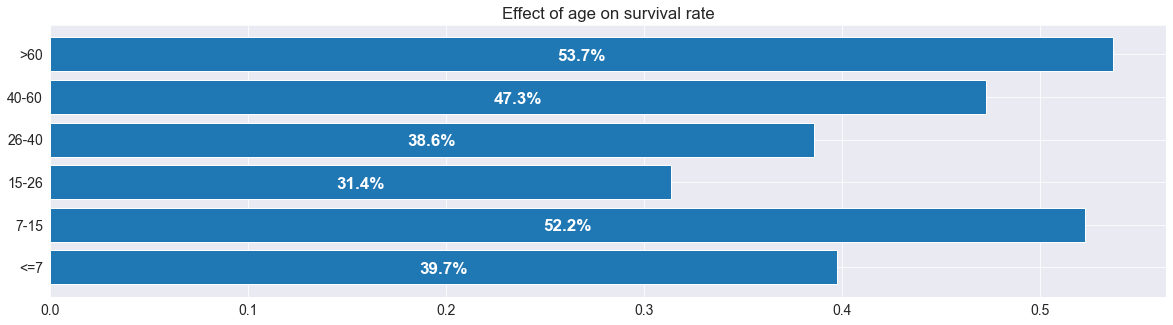

In [118]:
fig, ax = plt.subplots()
ax.barh(surv_by_agegroup.index, surv_by_agegroup.values)
for i in ax.patches:
    plt.text(i.get_width() / 2, i.get_y()+0.25,
             s=str(round((i.get_width()) * 100, 1)) + '%',
             fontsize=17, fontweight='bold',
             color='white', ha='center')
plt.title('Effect of age on survival rate')
plt.show()

=> As we can see, the probability to survive were the biggest for the people in the age of more then 60 and from the age of 7 to 15. It's also connected with the rules of the ship, that older people and children were the first to be put on the boats.
Fast half of the people in the age from 40 to 60 have survived. I believe it's connected with their financial position. They've probably had 1st class tickets and were the closest to the boats. But we have to prove this idea.
Another interesting outcome is that only 40% (12.5% less then next age group) of the people in the age less then 7 survived. Probably the most small children were from the families with the cheapest tickets, so they were to far away from the boats. And also some children were to small and mothers kept them to the last, hoping to be saved together.

Let's examine distribution of sex of survived passengers grouped by age group.

In [141]:
sex_of_survived_by_agegroup = TBS_train[TBS_train.Survived == 1].groupby(['AgeGroup', 'Sex']).count()['Survived'] \
                    .unstack().apply(lambda x: pd.Series([float(el)/sum(x) for el in x], index=['female', 'male']), axis=1)
sex_of_survived_by_agegroup

,female,male
AgeGroup,,
<=7,0.730096,0.269904
7-15,0.880113,0.119887
15-26,0.635560,0.364440
26-40,0.695101,0.304899
40-60,0.718842,0.281158
>60,0.841290,0.158710


<AxesSubplot:title={'center':'Distribution of sex of survived passengers grouped by age group'}, ylabel='AgeGroup'>

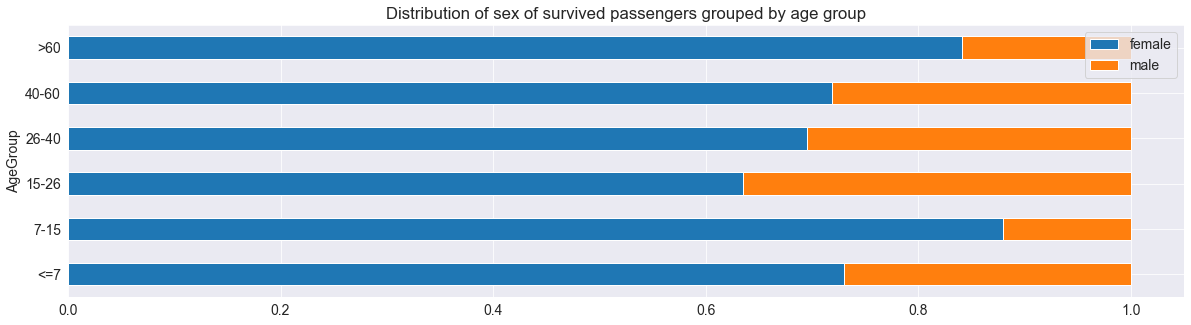

In [146]:
sex_of_survived_by_agegroup.plot(kind='barh', stacked=True, \
                                                    title='Distribution of sex of survived passengers grouped by age group')

It's worse to compare it with sex distribution of all passengers for each age group.

In [149]:
sex_by_agegroup = TBS_train.groupby(['AgeGroup', 'Sex']).count()['Survived'].unstack() \
                            .apply(lambda x: pd.Series([float(el)/sum(x) for el in x], index=['female', 'male']), axis=1)
sex_by_agegroup

,female,male
AgeGroup,,
<=7,0.510424,0.489576
7-15,0.666749,0.333251
15-26,0.305074,0.694926
26-40,0.369514,0.630486
40-60,0.453323,0.546677
>60,0.611002,0.388998


<AxesSubplot:title={'center':'Distribution of sex of all passengers grouped by age group'}, ylabel='AgeGroup'>

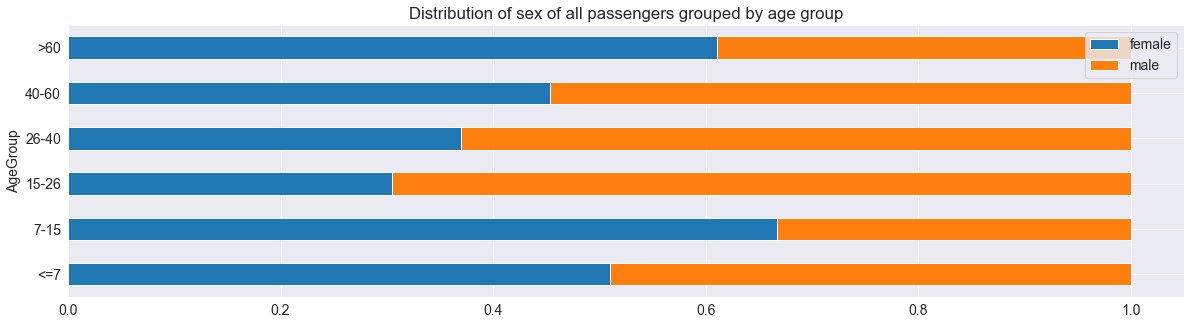

In [148]:
sex_by_agegroup.plot(kind='barh', stacked=True, title='Distribution of sex of all passengers grouped by age group')

So we can see, that in each age group, even among small children, sex influenced of the survival probability.

Let's look also at the distribution of age and sex summary...

for all passengers:

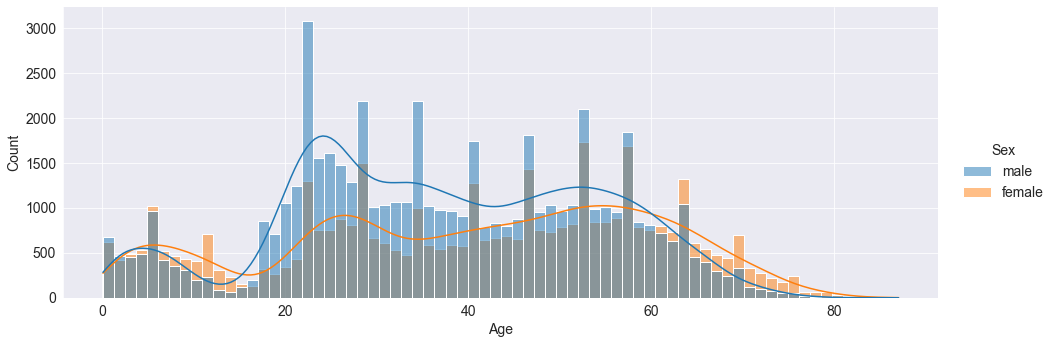

In [151]:
sns.displot(data=TBS_train, x='Age', hue='Sex', kde=True, aspect=2.7)

And only for survived passengers:

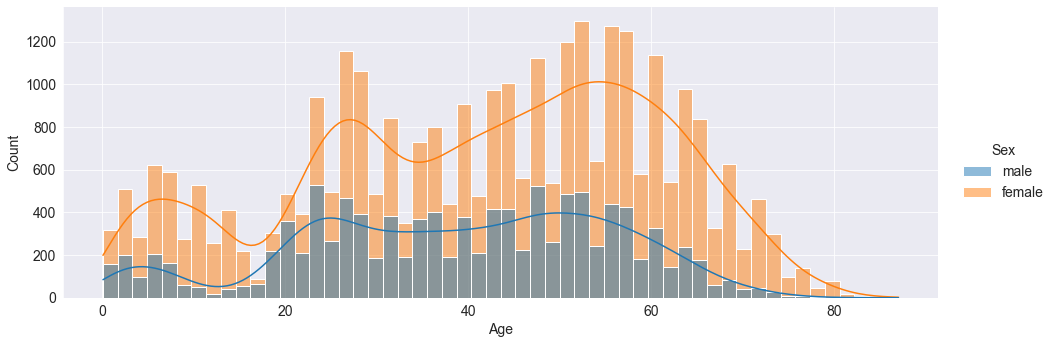

In [150]:
sns.displot(data=TBS_train[TBS_train.Survived==1], x='Age', hue='Sex', kde=True, aspect=2.7)

<AxesSubplot:ylabel='Pclass'>

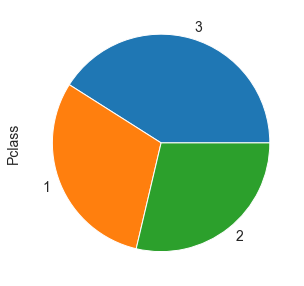

In [73]:
TBS_train.Pclass.value_counts().plot.pie()

In [74]:
TBS_train.groupby('Pclass').mean()['Survived']

Pclass
1    0.579779
2    0.525018
3    0.247305
Name: Survived, dtype: float64

=> Вероятность выжить у пассажиров второго класса была в два раза выше, чем у пассажиров третьего класса. Пассажиры первого класса выживали с вероятностью на 5% выше, чем пассажиры второго.

<AxesSubplot:title={'center':'Probability of surviving based on Pclass'}, ylabel='Pclass'>

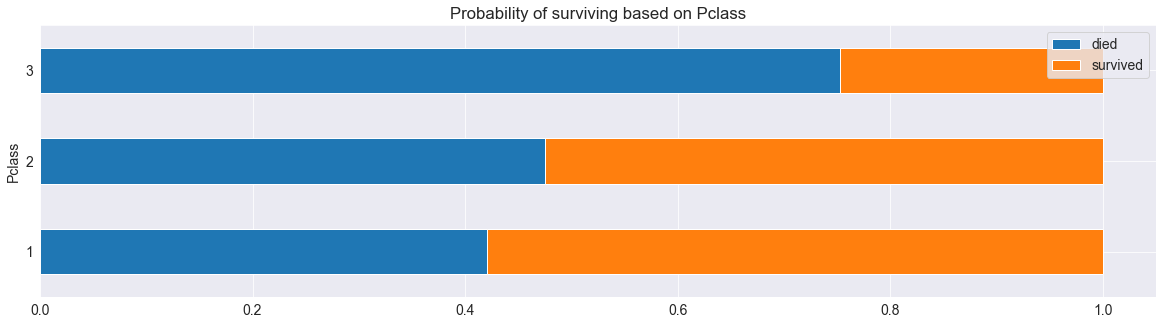

In [75]:
TBS_train.groupby(['Pclass', 'Survived']).size().unstack().apply(lambda x: pd.Series([float(el)/sum(x) for el in x], \
          index=['died', 'survived']), axis=1).plot(kind='barh', stacked=True, \
                                                    title='Probability of surviving based on Pclass')

<AxesSubplot:xlabel='SibSp'>

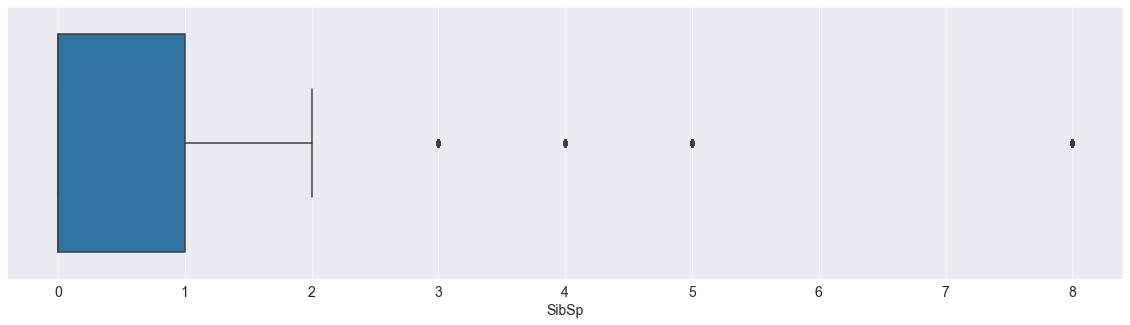

In [22]:
sns.boxplot(x = TBS_train.SibSp)

In [27]:
TBS_train[TBS_train.SibSp == 8]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
204,1,3,"Bennett, Shirley",female,12.0,8,1,21620,12.51,NaN,C
692,0,2,"Gomes, James",male,35.0,8,2,A/5,24.55,NaN,S
708,0,1,"Ulloa, Mathew",male,53.0,8,1,13352,195.94,A7232,S
1000,1,3,"Harper, Barbara",female,33.0,8,1,28882,64.99,NaN,S
1230,0,3,"Carlson, Douglas",male,29.0,8,1,338099,9.26,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99250,0,2,"Medina, Bernard",male,33.0,8,1,13144,25.15,NaN,S
99301,1,2,"Henderson, Stacy",female,1.0,8,1,17419,25.11,NaN,S
99356,0,3,"Gellert, Ray",male,36.0,8,0,461666,12.21,NaN,S


<AxesSubplot:xlabel='Parch'>

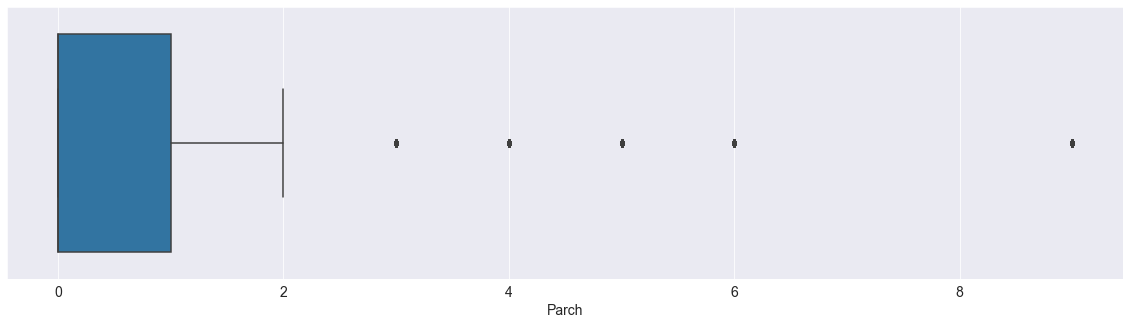

In [23]:
sns.boxplot(x = TBS_train.Parch)

In [28]:
TBS_train[TBS_train.Parch > 8]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1436,0,1,"Russell, Leona",female,23.0,1,9,PC 27443,92.25,B6812,S
2124,1,3,"Martinez, Megan",female,29.0,0,9,22900,11.12,NaN,C
2610,0,3,"Cote, Theresa",female,7.0,0,9,21071,7.54,NaN,S
3732,0,3,"Folks, Kent",male,35.0,0,9,429586,10.11,NaN,S
3920,0,1,"Aivao, Richard",male,55.0,1,9,455541,36.47,B13857,S
...,...,...,...,...,...,...,...,...,...,...,...
96654,1,1,"Treaster, Alan",male,58.0,1,9,237174,123.46,B13836,S
96709,0,3,"Schiele, George",male,38.0,0,9,382811,12.93,NaN,S
96762,0,2,"Hummel, Sharon",female,42.0,0,9,C.A. 7923,29.93,NaN,S


<AxesSubplot:xlabel='Fare'>

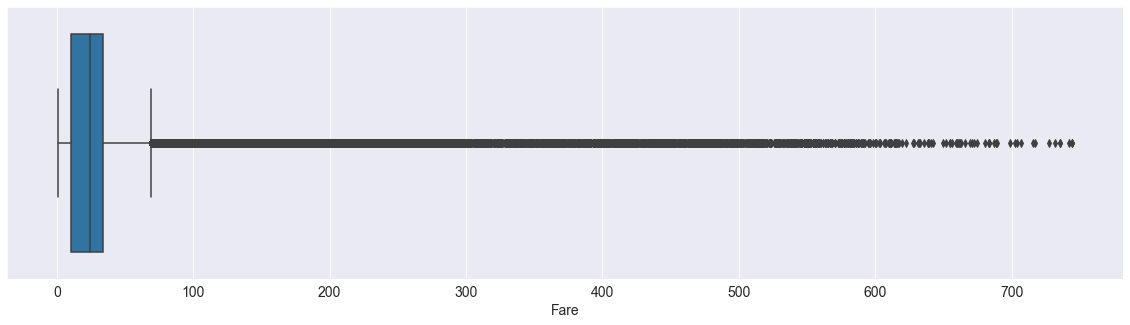

In [9]:
# Посмотрим, нет ли подозрительных выбросов в цене
sns.boxplot(x = TBS_train.Fare)

<AxesSubplot:xlabel='Fare'>

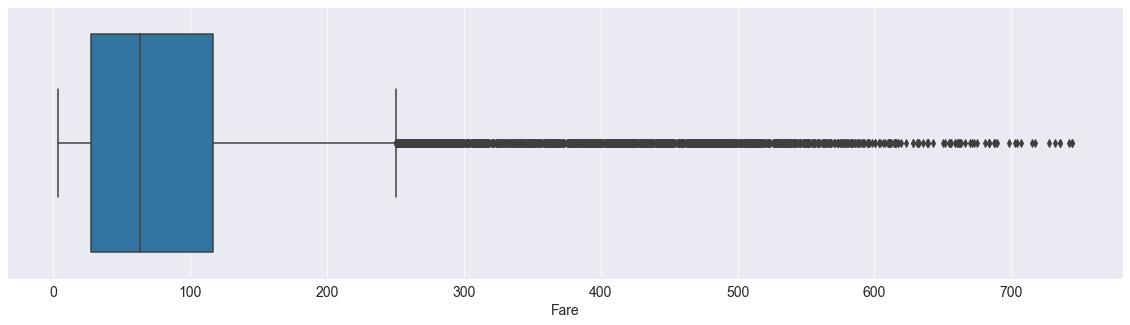

In [10]:
# Distribution of fare for the 1st class
sns.boxplot(x = TBS_train[TBS_train.Pclass == 1].Fare)

<AxesSubplot:xlabel='Fare'>

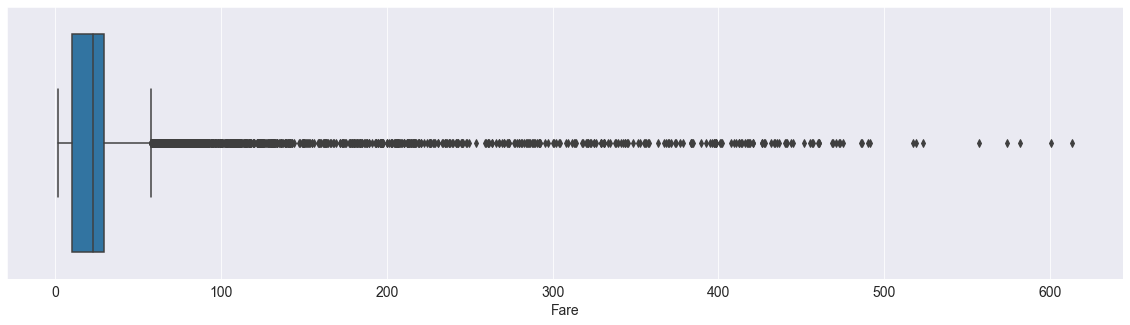

In [11]:
# Distribution of fare for the 2nd class
sns.boxplot(x = TBS_train[TBS_train.Pclass == 2].Fare)

<AxesSubplot:xlabel='Fare'>

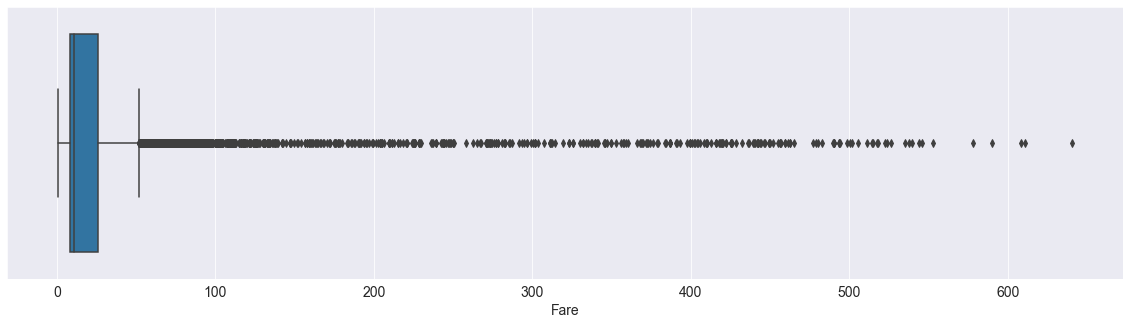

In [12]:
# Distribution of fare for the 3rd class
sns.boxplot(x = TBS_train[TBS_train.Pclass == 3].Fare)

In [13]:
TBS_train.groupby('Pclass').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,30275.0,92.653113,99.821850,3.38,27.89,63.58,116.875,744.66
2,28637.0,25.756003,34.849110,1.72,10.17,22.72,29.210,613.43
3,40954.0,20.618226,32.621763,0.68,8.54,10.96,25.770,640.79


<AxesSubplot:title={'center':'Fare Distribution'}, ylabel='Frequency'>

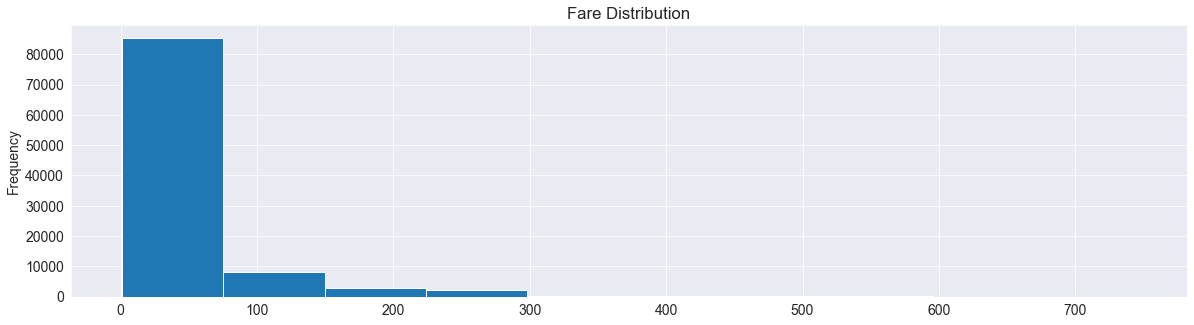

In [76]:
TBS_train.Fare.plot(kind='hist', title='Fare Distribution')

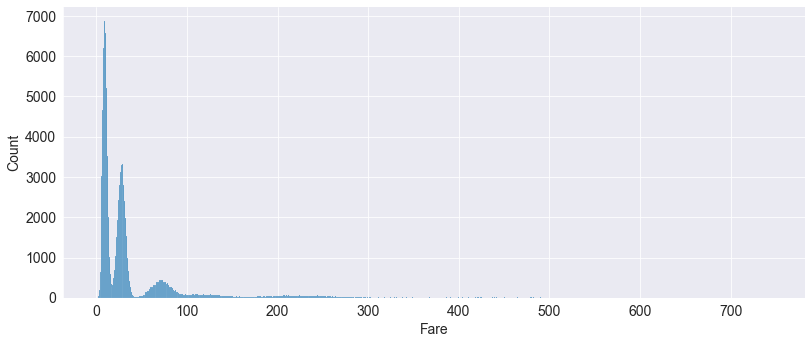

In [117]:
sns.displot(TBS_train.Fare, aspect=2.3)

In [12]:
data_with_cabin = TBS_train[~TBS_train.Cabin.isna()]
data_with_cabin['Deck'] = data_with_cabin.Cabin.str.get(0)
data_with_cabin

<ipython-input-12-1c098d59c7eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_cabin['Deck'] = data_with_cabin.Cabin.str.get(0)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,C
8,0,1,"Wardlaw, Michael",male,27.0,2,1,474849,73.02,A7253,S,A
9,0,2,"Greigo, Rudy",male,66.0,0,0,6981,9.14,D2969,C,D
11,0,1,"Telschow, Robert",male,60.0,0,0,19600,31.50,A9055,S,A
12,0,3,"Stewart, Pat",male,36.0,0,0,434108,9.34,C8674,S,C
...,...,...,...,...,...,...,...,...,...,...,...,...
99967,0,1,"Harrier, Stacey",male,49.0,2,0,402064,225.51,A4590,S,A
99989,1,1,"Harris, Amy",female,64.0,0,1,27728,31.66,D12975,C,D
99991,0,1,"Hogan, Todd",male,53.0,0,5,CA 48075,30.09,B19289,Q,B


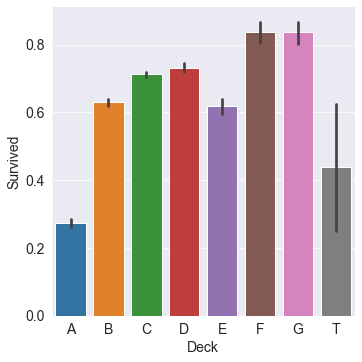

In [13]:
sns.catplot(x="Deck", y="Survived",  kind="bar", data=data_with_cabin.sort_values(by='Deck'))

Let's try to look for patterns in the missing data.

In [25]:
na_age = TBS_train[TBS_train.Age.isna()]
na_age.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
66446,1,3,"Hollis, Norma",female,NaN,0,0,15981,10.51,NaN,C
73456,0,1,"Hess, Madeline",female,NaN,0,0,PC 12362,76.14,C8810,C
77471,1,1,"Ehsan, Kenneth",male,NaN,0,0,SC/A.3 27878,328.23,NaN,S
74668,0,2,"Mariano, Wanda",female,NaN,0,0,A. 45145,14.26,NaN,C
8179,0,3,"Allyn, Robert",male,NaN,0,0,F.C.C. 38905,9.84,NaN,S
75191,0,1,"Altic, Margaret",female,NaN,0,0,F.C.C. 19716,33.06,C16569,C
98078,1,2,"Mcginnis, Walter",male,NaN,0,0,PC 45876,68.62,B13842,Q
36783,1,2,"Marshall, Ramon",male,NaN,0,0,3833008,28.04,NaN,S
25797,1,1,"Lane, Sarah",female,NaN,1,3,69919,64.78,B21900,Q


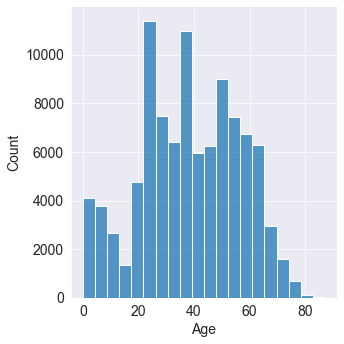

In [113]:
sns.displot(TBS_train.Age, bins=20)

In [5]:
TBS_train['Agegroup'] = (TBS_train.Age // 10).astype(int)
TBS_train

ValueError: Cannot convert non-finite values (NA or inf) to integer

<AxesSubplot:title={'center':'Probability of surviving based on age group'}, xlabel='Agegroup'>

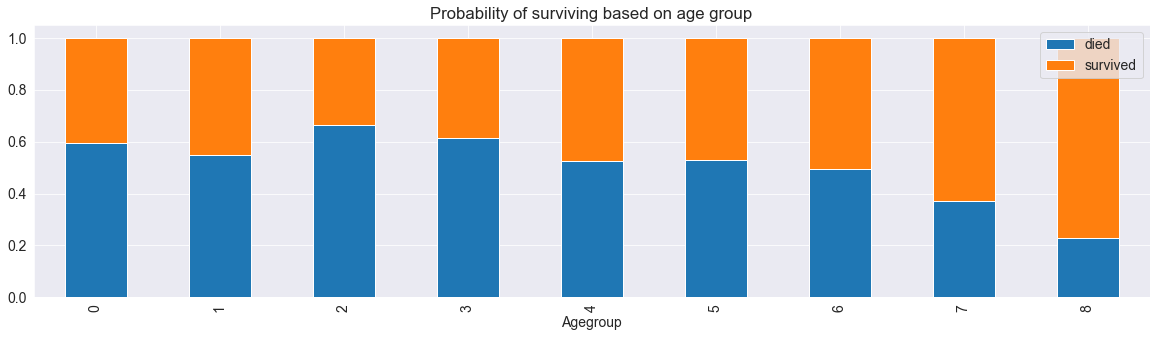

In [79]:
TBS_train.groupby(['Agegroup', 'Survived']).size().unstack().apply(lambda x: pd.Series([float(el)/sum(x) for el in x], index=['died', 'survived']), axis=1).plot(kind='bar', stacked=True, title='Probability of surviving based on age group')

In [27]:
na_age.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,3292.000000,3292.000000,0.0,3292.000000,3292.000000,3287.000000
mean,0.411908,2.127582,NaN,0.381531,0.433475,43.608126
std,0.492253,0.834244,NaN,0.824422,0.900797,70.970441
min,0.000000,1.000000,NaN,0.000000,0.000000,2.790000
25%,0.000000,1.000000,NaN,0.000000,0.000000,10.000000
50%,0.000000,2.000000,NaN,0.000000,0.000000,23.890000
75%,1.000000,3.000000,NaN,1.000000,1.000000,32.670000
max,1.000000,3.000000,NaN,8.000000,9.000000,732.010000


In [53]:
na_ticket = TBS_train[TBS_train.Ticket.isna()]
na_ticket.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
13489,0,3,"Pfeifer, Salvador",male,26.0,0,0,NaN,5.28,NaN,S
95677,0,3,"Daugherty, Bryant",male,39.0,1,0,NaN,11.61,NaN,S
93432,0,3,"Wiley, Rosa",female,22.0,0,0,NaN,11.14,NaN,S
64171,0,3,"Cofer, Billie",female,24.0,0,0,NaN,6.48,NaN,S
47109,1,3,"Millhiser, Lina",female,57.0,3,0,NaN,7.31,NaN,S
13064,0,2,"Brunetti, Chase",male,39.0,3,0,NaN,10.63,NaN,S
82672,1,2,"Webb, Rachel",female,27.0,0,0,NaN,8.77,NaN,S
14612,0,3,"Mattews, Richard",male,28.0,0,0,NaN,7.19,NaN,S
24253,0,2,"Choudhury, Gary",male,20.0,0,0,NaN,6.10,NaN,S


In [31]:
na_ticket.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,4623.000000,4623.000000,4623.000000,4623.000000,4623.000000,4617.000000
mean,0.521955,2.810080,35.095609,0.479559,0.238590,13.339950
std,0.499572,0.406899,17.934545,1.103260,0.662371,15.035303
min,0.000000,1.000000,0.080000,0.000000,0.000000,2.460000
25%,0.000000,3.000000,23.000000,0.000000,0.000000,8.320000
50%,1.000000,3.000000,29.000000,0.000000,0.000000,9.980000
75%,1.000000,3.000000,50.000000,0.000000,0.000000,12.510000
max,1.000000,3.000000,85.000000,8.000000,6.000000,548.050000


In [55]:
na_ticket[na_ticket.Fare.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 5007 to 50570
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  6 non-null      int64  
 1   Pclass    6 non-null      int64  
 2   Name      6 non-null      object 
 3   Sex       6 non-null      object 
 4   Age       6 non-null      float64
 5   SibSp     6 non-null      int64  
 6   Parch     6 non-null      int64  
 7   Ticket    0 non-null      object 
 8   Fare      0 non-null      float64
 9   Cabin     1 non-null      object 
 10  Embarked  6 non-null      object 
dtypes: float64(2), int64(4), object(5)
memory usage: 576.0+ bytes


Заметим, что в данных, где нет информации ни о билете, ни о цене, имеются все остальные данные, кроме кабины

In [59]:
na_ticket[na_ticket.Fare.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
5007,1,3,"Philbrick, Kelly",female,50.0,0,0,NaN,NaN,NaN,S
6575,0,3,"Roberts, Edith",female,11.0,0,2,NaN,NaN,NaN,S
7520,0,3,"Gullixson, Mary",female,66.0,0,0,NaN,NaN,NaN,S
22347,1,2,"Maurice, Lakeisha",female,38.0,0,0,NaN,NaN,F18774,S
31036,1,3,"Mckee, James",male,7.0,0,0,NaN,NaN,NaN,S
50570,1,2,"Bowens, Ruby",female,58.0,1,0,NaN,NaN,NaN,S


<AxesSubplot:ylabel='Embarked'>

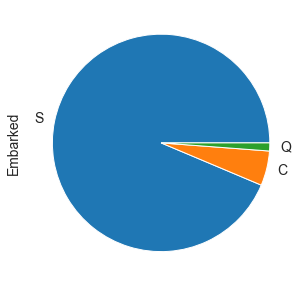

In [32]:
na_ticket.Embarked.value_counts().plot.pie()

<AxesSubplot:ylabel='Embarked'>

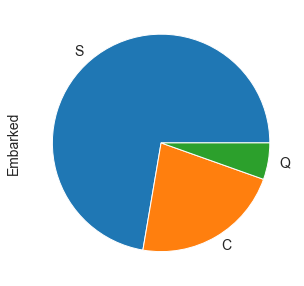

In [33]:
TBS_train.Embarked.value_counts().plot.pie()

=> Можно заметить, что большинство пассажиров, номер билетов которых отсутствует в базе данных, зашли на паром в Southhampton. Доля этих пассажиров больше чем общая по всей популяции. Данный порт был местом отплытия Титаника.

In [37]:
na_fare = TBS_train[TBS_train.Fare.isna()]
na_fare.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
56770,1,2,"Bunting, Jack",male,37.0,1,0,43595,NaN,NaN,C
5007,1,3,"Philbrick, Kelly",female,50.0,0,0,NaN,NaN,NaN,S
97944,1,3,"Engleberg, Melba",female,66.0,0,1,SC/PARIS 300188,NaN,NaN,S
76798,0,3,"Lybbert, David",male,22.0,1,0,207845,NaN,NaN,S
31402,0,2,"Arnold, Jeffrey",male,9.0,1,2,CA. 39294,NaN,NaN,S
1999,0,3,"Flatley, Trena",female,3.0,1,2,457224,NaN,NaN,S
4289,1,2,"Clark, Francis",male,7.0,0,1,450380,NaN,NaN,S
78110,0,2,"Stevenson, Steven",male,22.0,0,0,7318,NaN,NaN,S
13685,0,1,"Rusk, Frederick",male,36.0,0,3,S.C./PARIS 3874867,NaN,A7251,S


In [39]:
na_fare.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,134.000000,134.000000,134.000000,134.000000,134.000000,0.0
mean,0.455224,2.089552,38.544179,0.313433,0.477612,NaN
std,0.499860,0.826831,17.782044,0.642105,0.801469,NaN
min,0.000000,1.000000,0.920000,0.000000,0.000000,NaN
25%,0.000000,1.000000,25.000000,0.000000,0.000000,NaN
50%,0.000000,2.000000,39.000000,0.000000,0.000000,NaN
75%,1.000000,3.000000,53.000000,0.750000,1.000000,NaN
max,1.000000,3.000000,73.000000,4.000000,3.000000,NaN


In [47]:
na_fare[na_fare.Ticket.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
5007,1,3,"Philbrick, Kelly",female,50.0,0,0,NaN,NaN,NaN,S
6575,0,3,"Roberts, Edith",female,11.0,0,2,NaN,NaN,NaN,S
7520,0,3,"Gullixson, Mary",female,66.0,0,0,NaN,NaN,NaN,S
22347,1,2,"Maurice, Lakeisha",female,38.0,0,0,NaN,NaN,F18774,S
31036,1,3,"Mckee, James",male,7.0,0,0,NaN,NaN,NaN,S
50570,1,2,"Bowens, Ruby",female,58.0,1,0,NaN,NaN,NaN,S


In [62]:
not_na_cabin = TBS_train[~TBS_train.Cabin.isna()]
not_na_cabin

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,39.0,2,0,209245,27.14,C12239,S
8,0,1,"Wardlaw, Michael",male,27.0,2,1,474849,73.02,A7253,S
9,0,2,"Greigo, Rudy",male,66.0,0,0,6981,9.14,D2969,C
11,0,1,"Telschow, Robert",male,60.0,0,0,19600,31.50,A9055,S
12,0,3,"Stewart, Pat",male,36.0,0,0,434108,9.34,C8674,S
...,...,...,...,...,...,...,...,...,...,...,...
99967,0,1,"Harrier, Stacey",male,49.0,2,0,402064,225.51,A4590,S
99989,1,1,"Harris, Amy",female,64.0,0,1,27728,31.66,D12975,C
99991,0,1,"Hogan, Todd",male,53.0,0,5,CA 48075,30.09,B19289,Q


In [63]:
not_na_cabin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32134 entries, 0 to 99995
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  32134 non-null  int64  
 1   Pclass    32134 non-null  int64  
 2   Name      32134 non-null  object 
 3   Sex       32134 non-null  object 
 4   Age       32134 non-null  float64
 5   SibSp     32134 non-null  int64  
 6   Parch     32134 non-null  int64  
 7   Ticket    32051 non-null  object 
 8   Fare      32092 non-null  float64
 9   Cabin     32134 non-null  object 
 10  Embarked  32046 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.9+ MB


<AxesSubplot:ylabel='Embarked'>

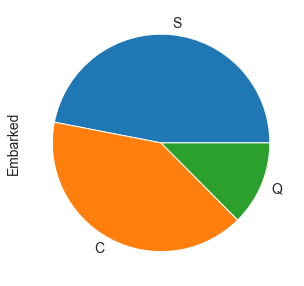

In [64]:
not_na_cabin.Embarked.value_counts().plot.pie()

<AxesSubplot:ylabel='Sex'>

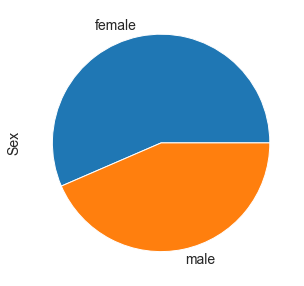

In [66]:
not_na_cabin.Sex.value_counts().plot.pie()

# Summary

В процессе анализа имеющихся данных были сделаны следующие выводы:

 * В данных, где отсутствует информация и о номере билета, и о его цене, имеются все остальные данные, кроме номера кабины
 * Большинство пассажиров, номера билетов которых отсутствуют в базе данных, зашли на паром в порту Southhampton. Доля этих пассажиров больше, чем общая по всей популяции. Данный порт был местом отплытия Титаника.
 * Колонка Fare - единственная из количественных непрерывных характеристик, являющаяся бимодальной. Но при этом стоит учитывать, что значения обеих мод крайне близки.

<AxesSubplot:xlabel='Age', ylabel='count'>

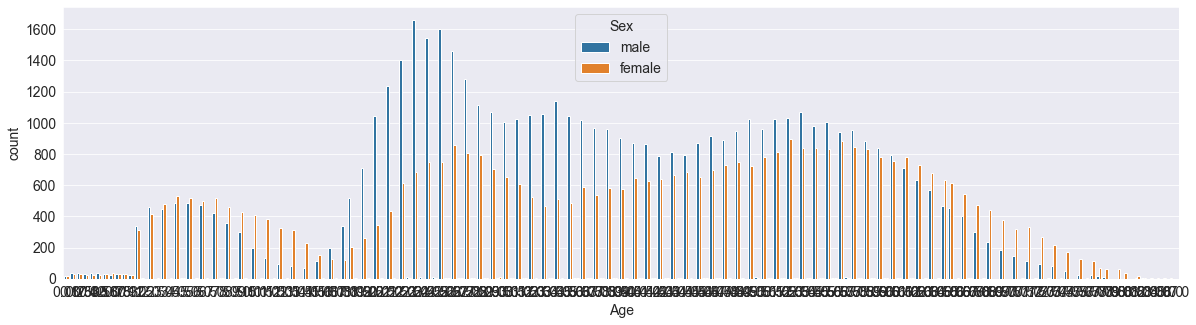

In [7]:
sns.countplot(x='Age', hue='Sex', data=TBS_train)